In [369]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2)
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from scipy import stats
prefix=""
import math
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount=True)
prefix = '/content/gdrive/My Drive/DS3001 Team/Model Files/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [370]:
#!pip uninstall xgboost
!pip install '/content/gdrive/My Drive/DS3001 Team/Model Files/xgboost-0.81-py2.py3-none-manylinux1_x86_64.whl'
import xgboost as xgb

In [0]:
def acc(y, yhat):
    MSE = (1/len(yhat))*np.dot((y-yhat).T,(y-yhat))   
    RMSE = np.sqrt((1/len(yhat))*np.dot((y-yhat).T,(y-yhat)))
    RMSLE = np.sqrt((1/len(yhat))*np.dot((np.log(y)-np.log(yhat)).T,(np.log(y)-np.log(yhat))))
    return MSE, RMSE, RMSLE

In [0]:
def get_categorical(x):
    x = pd.get_dummies(x, dummy_na = True).astype(float)
    return x

In [0]:
def createVal(Xtr):
    Xtr = Xtr.sample(frac=1,random_state=4).reset_index(drop=True)
    Xva = Xtr.iloc[:int(Xtr.shape[0]*0.2),:]
    Xtr = Xtr.iloc[int(Xtr.shape[0]*0.2):,:]

    ytr = Xtr['SalePrice']
    Xtr = Xtr.drop('SalePrice',axis=1)
    yva = Xva['SalePrice']
    Xva = Xva.drop('SalePrice',axis=1)

    print(Xtr.shape, ytr.shape, Xva.shape, yva.shape)
    return Xtr, ytr, Xva, yva

In [0]:
def scale(Xtr,Xva,Xte, with_std=True):
    scaler = StandardScaler(with_std=with_std)
    scaler.fit(Xtr)
    Xtr = scaler.transform(Xtr)
    Xva = scaler.transform(Xva)
    Xte = scaler.transform(Xte)
    return Xtr, Xva, Xte

In [0]:
def keep_features(X1,X2,X3,features):
    X1 = X1.loc[:,features]
    X2 = X2.loc[:,features]
    X3 = X3.loc[:,features]
    print(X1.shape, X2.shape, X3.shape)
    return X1,X2,X3

In [0]:
def cv(regressor, folds):
    global Xtr, Xva, ytr, yva
    Xtr_concat = np.vstack((Xtr,Xva))
    ytr_concat = np.hstack((ytr,yva))
    RMSLE_tot_tr = 0
    RMSLE_tot_te = 0
    kf = KFold(n_splits=folds, shuffle = True, random_state=np.random.randint(100))
    kf.get_n_splits(Xtr_concat)

    for train_index, test_index in kf.split(Xtr_concat):
        #print("TRAIN:", train_index, "TEST:", test_index)
        Xtr_cv, Xva_cv = Xtr_concat[train_index], Xtr_concat[test_index]
        ytr_cv, yva_cv = ytr_concat[train_index], ytr_concat[test_index]
        regr = regressor
        regr.fit(Xtr_cv,ytr_cv)
        
        
        yhat = regr.predict(Xtr_cv)
        MSE, RMSE, RMSLE = acc(np.exp(ytr_cv), np.exp(yhat))
        print("Train: ", MSE, RMSE, RMSLE)
        
        RMSLE_tot_tr += RMSLE
        
        #testing
        yhat = regr.predict(Xva_cv)
        yhat[yhat<=0] = np.median(yva_cv)
        yhat[yhat>=13.75] = np.median(yva_cv)
        MSE, RMSE, RMSLE = acc(np.exp(yva_cv), np.exp(yhat))
        print("Test: ", MSE, RMSE, RMSLE)

        RMSLE_tot_te += RMSLE

    CV_RMSLE_tr = RMSLE_tot_tr/folds    
    CV_RMSLE_te = RMSLE_tot_te/folds
    print(CV_RMSLE_tr, CV_RMSLE_te)

In [377]:
Xtr = pd.read_csv(prefix+"train.csv")
Xtr = Xtr.iloc[:,1:]
Xte = pd.read_csv(prefix+"test.csv")
Xte = Xte.iloc[:,1:]
print(Xtr.shape, Xte.shape)

(1460, 80) (1459, 79)


In [0]:
pd.set_option('display.max_columns', Xtr.shape[1])

In [379]:
Xtr.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,10

# Output Log Transform, Outlier removal, and Month feature engineering

In [0]:
Xtr.SalePrice = np.log(Xtr.loc[:,['SalePrice']])

(array([  5.,  12.,  54., 184., 470., 400., 220.,  90.,  19.,   6.]),
 array([10.46024211, 10.7676652 , 11.07508829, 11.38251138, 11.68993448,
        11.99735757, 12.30478066, 12.61220375, 12.91962684, 13.22704994,
        13.53447303]),
 <a list of 10 Patch objects>)

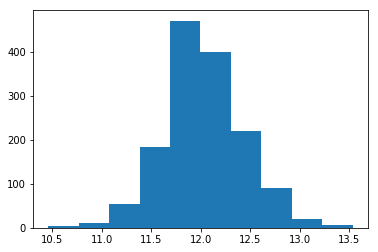

In [381]:
plt.hist(Xtr.SalePrice)

In [382]:
pd.DataFrame(Xtr.SalePrice).describe().astype(int)

,SalePrice
count,1460
mean,12
std,0
min,10
25%,11
50%,12
75%,12
max,13


# View Data

In [0]:
Xtr['LandSlope'] = Xtr['LandSlope'].map({'Gtl': 3.0, 'Mod': 2.0, 'Sev': 1.0}).astype(float)
Xte['LandSlope'] = Xte['LandSlope'].map({'Gtl': 3.0, 'Mod': 2.0, 'Sev': 1.0}).astype(float)

Xtr['BldgType'] = Xtr['BldgType'].map({'1Fam':1.0, '2fmCon': 2.0, 'Duplx': 6.0, 'Duplex': 6.0, 'TwnhsE': 4.0, 'TwnhsI': 3.0, 'Twnhs':3.5}).astype(float)
Xte['BldgType'] = Xte['BldgType'].map({'1Fam':1.0, '2fmCon': 2.0, 'Duplx': 6.0, 'Duplex': 6.0, 'TwnhsE': 4.0, 'TwnhsI': 3.0, 'Twnhs':3.5}).astype(float)

Xtr['HouseStyle'] = Xtr['HouseStyle'].map({'1Story': 1.0, '1.5Fin': 1.5, '1.5Unf': 1.25, '2Story': 2.0, '2.5Fin': 2.5, '2.5Unf': 2.25, 'SFoyer': 2.25, 'SLvl': 1.25}).astype(float)
Xte['HouseStyle'] = Xte['HouseStyle'].map({'1Story': 1.0, '1.5Fin': 1.5, '1.5Unf': 1.25, '2Story': 2.0, '2.5Fin': 2.5, '2.5Unf': 2.25, 'SFoyer': 2.25, 'SLvl': 1.25}).astype(float)

Xtr['ExterQual'] = Xtr['ExterQual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}).astype(float)
Xte['ExterQual'] = Xte['ExterQual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}).astype(float)

Xtr['ExterCond'] = Xtr['ExterCond'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}).astype(float)
Xte['ExterCond'] = Xte['ExterCond'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}).astype(float)

Xtr['BsmtQual'] = Xtr['BsmtQual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0, np.nan:0}).astype(float)
Xte['BsmtQual'] = Xte['BsmtQual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0, np.nan:0}).astype(float)

Xtr['BsmtCond'] = Xtr['BsmtCond'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0, np.nan:0}).astype(float)
Xte['BsmtCond'] = Xte['BsmtCond'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0, np.nan:0}).astype(float)

Xtr['BsmtExposure'] = Xtr['BsmtExposure'].map({'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0, np.nan:0}).astype(float)
Xte['BsmtExposure'] = Xte['BsmtExposure'].map({'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0, np.nan:0}).astype(float)

Xtr['BsmtFinType1'] = Xtr['BsmtFinType1'].map({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0, np.nan:0}).astype(float)
Xte['BsmtFinType1'] = Xte['BsmtFinType1'].map({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0, np.nan:0}).astype(float)

Xtr['BsmtFinType2'] = Xtr['BsmtFinType2'].map({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0, np.nan:0}).astype(float)
Xte['BsmtFinType2'] = Xte['BsmtFinType2'].map({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0, np.nan:0}).astype(float)

Xtr['HeatingQC'] = Xtr['HeatingQC'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}).astype(float)
Xte['HeatingQC'] = Xte['HeatingQC'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}).astype(float)

Xtr['KitchenQual'] = Xtr['KitchenQual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}).astype(float)
Xte['KitchenQual'] = Xte['KitchenQual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}).astype(float)

Xtr['Functional'] = Xtr['Functional'].map({'Typ':8,'Min1':7,'Min2':6,'Mod':5,'Maj1':4,'Maj2':3,'Sev':2,'Sal':1}).astype(float)
Xte['Functional'] = Xte['Functional'].map({'Typ':8,'Min1':7,'Min2':6,'Mod':5,'Maj1':4,'Maj2':3,'Sev':2,'Sal':1}).astype(float)

Xtr['FireplaceQu'] = Xtr['FireplaceQu'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0, np.nan:0}).astype(float)
Xte['FireplaceQu'] = Xte['FireplaceQu'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0, np.nan:0}).astype(float)

Xtr['GarageFinish'] = Xtr['GarageFinish'].map({'Fin':3, 'RFn':2, 'Unf':1, 'NA':0, np.nan:0}).astype(float)
Xte['GarageFinish'] = Xte['GarageFinish'].map({'Fin':3, 'RFn':2, 'Unf':1, 'NA':0, np.nan:0}).astype(float)

Xtr['GarageQual'] = Xtr['GarageQual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0, np.nan:0}).astype(float)
Xte['GarageQual'] = Xte['GarageQual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0, np.nan:0}).astype(float)

Xtr['GarageCond'] = Xtr['GarageCond'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0, np.nan:0}).astype(float)
Xte['GarageCond'] = Xte['GarageCond'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0, np.nan:0}).astype(float)

Xtr['PoolQC'] = Xtr['PoolQC'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0, np.nan:0}).astype(float)
Xte['PoolQC'] = Xte['PoolQC'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0, np.nan:0}).astype(float)

Xtr['Fence'] = Xtr['Fence'].map({'GdPrv':2, 'MnPrv':1, 'GdWo':2, 'MnWw':1, 'NA':0, np.nan:0}).astype(float)
Xte['Fence'] = Xte['Fence'].map({'GdPrv':2, 'MnPrv':1, 'GdWo':2, 'MnWw':1, 'NA':0, np.nan:0}).astype(float)

Xtr.MasVnrArea.fillna(0,inplace=True)
Xte.MasVnrArea.fillna(0,inplace=True)

Xtr.GarageYrBlt.fillna(0,inplace=True)
Xte.GarageYrBlt.fillna(0,inplace=True)

In [0]:
#clean training data and ensure testing data is of same size
Xtr = get_categorical(Xtr)
Xte = get_categorical(Xte)

In [385]:
missing_cols=[]
for i in Xtr.columns:
    if i not in Xte.columns:
        missing_cols.append(i)
for i in missing_cols:
    if i!='SalePrice':
        Xtr = Xtr.drop(i,axis=1)
print(missing_cols, Xtr.shape, Xte.shape)

['SalePrice', 'Utilities_NoSeWa', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'RoofMatl_ClyTile', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior2nd_Other', 'Heating_Floor', 'Heating_OthW', 'Electrical_Mix', 'MiscFeature_TenC'] (1460, 227) (1459, 226)


In [386]:
extra_cols=[]
for i in Xte.columns:
    if i not in Xtr.columns:
        extra_cols.append(i)
for i in extra_cols:
    Xte = Xte.drop(i, axis=1)
extra_cols
print(extra_cols, Xtr.shape, Xte.shape)

[] (1460, 227) (1459, 226)


In [387]:
#check for unhandled nulls
Xte.isnull().sum()[Xte.isnull().sum()>0]

LotFrontage     227
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
KitchenQual       1
Functional        2
GarageCars        1
GarageArea        1
dtype: int64

# Design Cyclic Month Feature

In [0]:
Xtr['month_sin'] = np.sin((Xtr.MoSold-1)*(2.*np.pi/12))
Xtr['month_cos'] = np.cos((Xtr.MoSold-1)*(2.*np.pi/12))
Xte['month_sin'] = np.sin((Xte.MoSold-1)*(2.*np.pi/12))
Xte['month_cos'] = np.cos((Xte.MoSold-1)*(2.*np.pi/12))

In [0]:
Xtr = Xtr.drop('MoSold',axis=1)
Xte = Xte.drop('MoSold',axis=1)

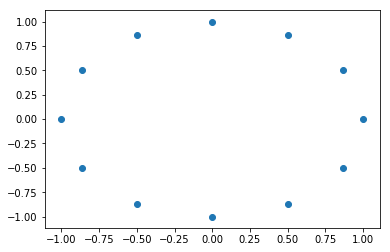

In [390]:
mo = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
x = np.sin((mo-1)*(2.*np.pi/12))
y = np.cos((mo-1)*(2.*np.pi/12))
plt.scatter(x,y)

#Remove Outliers

In [0]:
t = 4000

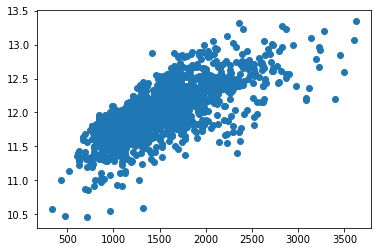

In [392]:
plt.scatter(Xtr.GrLivArea[Xtr.GrLivArea<t],Xtr.SalePrice[Xtr.GrLivArea<t])

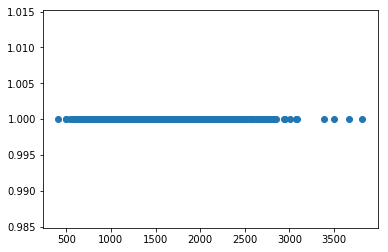

In [393]:
plt.scatter(Xte.GrLivArea[Xte.GrLivArea<t],np.ones((Xte.GrLivArea[Xte.GrLivArea<t].shape)))

In [394]:
print(Xtr.shape)
Xtr = Xtr[Xtr.GrLivArea<t]
print(Xtr.shape)

(1460, 228)
(1456, 228)


#Remove Outliers

In [0]:
t = 3000

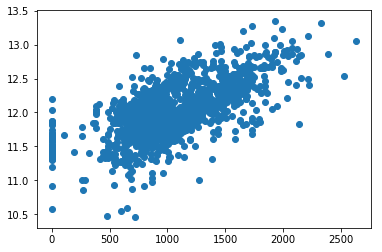

In [396]:
plt.scatter(Xtr.TotalBsmtSF[Xtr.TotalBsmtSF<t],Xtr.SalePrice[Xtr.TotalBsmtSF<t])

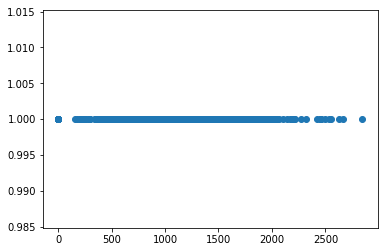

In [397]:
plt.scatter(Xte.TotalBsmtSF[Xte.TotalBsmtSF<t],np.ones((Xte.TotalBsmtSF[Xte.TotalBsmtSF<t].shape)))

In [398]:
print(Xtr.shape)
Xtr = Xtr[Xtr.TotalBsmtSF<t]
print(Xtr.shape)

(1456, 228)
(1453, 228)


# Predict Lot Frontage to Fill Null Values

In [0]:
cols = Xtr.columns[(Xtr.columns != 'LotFrontage') & (Xtr.columns != 'SalePrice')]
Xtr_temp_full = Xtr.loc[:, cols].dropna(axis=1)
Xtr_temp = pd.concat([Xtr_temp_full, Xtr.loc[:, ['LotFrontage']]], axis=1).dropna()
x = Xtr_temp.loc[:, Xtr_temp.columns != 'LotFrontage']
y = Xtr_temp.loc[:, ['LotFrontage']]

reg = LinearRegression()
reg.fit(x,y)

Xtr.LotFrontage.fillna(pd.Series(reg.predict(Xtr_temp_full).flatten()),inplace=True)


Xte_temp_full = Xte.loc[:,cols].dropna()
Xte.LotFrontage.fillna(pd.Series(reg.predict(Xte_temp_full).flatten()),inplace=True)

In [400]:
#check for unhandled nulls
Xte.isnull().sum()[Xte.isnull().sum()>0]

BsmtFinSF1      1
BsmtFinSF2      1
BsmtUnfSF       1
TotalBsmtSF     1
BsmtFullBath    2
BsmtHalfBath    2
KitchenQual     1
Functional      2
GarageCars      1
GarageArea      1
dtype: int64

In [401]:
#clean training data and ensure testing data is of same size
Xtr = get_categorical(Xtr)
Xte = get_categorical(Xte)
Xtr = Xtr.apply(lambda s: s.fillna(0), axis = 0)
Xte = Xte.apply(lambda s: s.fillna(0), axis = 0)
print(Xtr.shape, Xte.shape)

(1453, 228) (1459, 227)


In [402]:
#check for unhandled nulls
Xte.isnull().sum()[Xte.isnull().sum()>0]

Series([], dtype: int64)

# Create Validation Set

In [403]:
Xtr_full, ytr, Xva_full, yva = createVal(Xtr)
Xte_full = Xte

(1163, 227) (1163,) (290, 227) (290,)


In [404]:
Xtr_full.head()

,MSSubClass,LotFrontage,LotArea,LandSlope,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,...,CentralAir_nan,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Electrical_nan,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_nan,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PavedDrive_nan,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_nan,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan,month_sin,month_cos
290,90.0,67.000000,8777.0,3.0,6.0,1.5,5.0,7.0,1900.0,2003.0,0.0,3.0,3.0,3.0,3.0,1.0,5.0,1084.0,1.0,0.0,188.0,1272.0,4.0,1272.0,928.0,0.0,2200.0,2.0,0.0,2.0,2.0,4.0,2.0,3.0,9.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-8.660254e-01,-5.000000e-01
291,120.0,59.000000,8198.0,3.0,4.0,1.0,7.0,5.0,2004.0,2004.0,146.0,4.0,3.0,4.0,3.0,3.0,6.0,720.0,1.0,0.0,638.0,1358.0,5.0,1358.0,0.0,0.0,1358.0,1.0,0.0,2.0,0.0,2.0,1.0,4.0,6.0,8.0,1.0,4.0,2004.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.224647e-16,-1.000000e+00
292,60.0,104.000000,13518.0,3.0,1.0,2.0,9.0,5.0,2008.0,2009.0,860.0,5.0,3.0,5.0,3.0,1.0,1.0,0.0,1.0,0.0,1926.0,1926.0,5.0,1966.0,1174.0,0.0,3140.0,0.0,0.0,3.0,1.0,4.0,1.0,5.0,11.0,8.0,2.0,4.0,2009.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.224647e-16,-1.000000e+00
293,20.0,80.000000,10000.0,3.0,1.0,1.0,5.0,6.0,1961.0,1983.0,0.0,3.0,3.0,3.0,3.0,1.0,4.0,594.0,1.0,0.0,270.0,864.0,5.0,1144.0,0.0,0.0,1144.0,1.0,0.0,1.0,0.0,3.0,1.0,3.0,6.0,8.0,1.0,3.0,1961.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.660254e-01,5.000000e-01
294,20.0,73.247136,26142.0,3.0,1.0,1.0,5.0,7.0,1962.0,1962.0,189.0,3.0,3.0,3.0,3.0,1.0,3.0,593.0,1.0,0.0,595.0,1188.0,3.0,1188.0,0.0,0.0,1188.0,0.0,0.0,1.0,0.0,3.0,1.0,3.0,6.0,8.0,0.0,0.0,1962.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.000000e+00,6.123234e-17


In [0]:
Xtr_full = Xtr_full.reindex(sorted(Xtr_full.columns), axis=1)
Xva_full = Xva_full.reindex(sorted(Xva_full.columns), axis=1)
Xte_full = Xte_full.reindex(sorted(Xte_full.columns), axis=1)

In [0]:
Xtr, Xva, Xte = scale(Xtr_full,Xva_full,Xte_full)

In [0]:
Xtr_orig = Xtr_full
Xva_orig = Xva_full
Xte_orig = Xte_full

# Linear Regression

In [408]:
lr = LinearRegression()
lr.fit(Xtr,ytr)

#training stats
yhat = lr.predict(Xtr)
MSE, RMSE, RMSLE = acc(np.exp(ytr), np.exp(yhat))
print(MSE, RMSE, RMSLE)

#testing stats
yhat = lr.predict(Xva)
MSE, RMSE, RMSLE = acc(np.exp(yva), np.exp(yhat))
print(MSE, RMSE, RMSLE)

270763331.2652157 16454.887762157956 0.09350745077318101
539892994.8605708 23235.59757915795 0.13148070106782697


# Lasso

In [409]:
#for i in range(1441,1442):
#for i in range(783,784):
for i in np.arange(0.0065,0.00651,0.0001):
    # Lasso Regularization (lambda optimization)
    regr = linear_model.Lasso(alpha=i, max_iter = 1000)
    regr.fit(Xtr, ytr)

    print(i)

    #training stats
    yhat = regr.predict(Xtr)
    MSE, RMSE, RMSLE = acc(np.exp(ytr), np.exp(yhat))
    print(MSE, RMSE, RMSLE)

    #testing stats
    yhat = regr.predict(Xva)
    MSE, RMSE, RMSLE = acc(np.exp(yva), np.exp(yhat))
    print(MSE, RMSE, RMSLE)

0.0065
368515051.2364627 19196.745850181553 0.10663022525694905
498444078.88559896 22325.861212629603 0.10611923152988816


In [410]:
cv(regr, 10)

Train:  363165187.69398886 19056.893442898527 0.10527364095880763
Test:  641600410.9120842 25329.832429609247 0.12003414388397192
Train:  391510598.2763394 19786.626753348824 0.10655473417894099
Test:  243522422.63093862 15605.204985226519 0.10290871622468481
Train:  375979357.63440025 19390.187147998346 0.10600497647529793
Test:  440486283.1757788 20987.76508291864 0.11154753441214076
Train:  386749827.8985638 19665.956063679278 0.10649456006925474
Test:  300790265.09277797 17343.306060056082 0.1039685687696064
Train:  389632066.0500037 19739.09993008809 0.10536222278960058
Test:  345417495.70912355 18585.410829710585 0.1214463780939195
Train:  377299670.9663459 19424.203226035963 0.10558070227542629
Test:  416806420.2567948 20415.837486049764 0.11558464048479815
Train:  381907587.42274165 19542.456023303253 0.10672659801067179
Test:  352540563.53163624 18776.063579239293 0.10335739393329466
Train:  367431296.92687833 19168.497513547543 0.10438969369639238
Test:  485339852.5667915 220

In [411]:
count = (regr.coef_ != 0).sum()
coefs = np.abs(regr.coef_ )
best_fea_in = coefs.argsort()[::-1][0:count]
imp_fea = Xtr_full.columns[best_fea_in]
imp_fea = list(imp_fea)
print("Number of Features: " + str(len(imp_fea)) + " \nTop 10 Features: " + str(imp_fea[0:10]))

Number of Features: 64 
Top 10 Features: ['GrLivArea', 'OverallQual', 'YearBuilt', 'TotalBsmtSF', 'BsmtFinSF1', 'OverallCond', 'MSZoning_C (all)', 'GarageCars', 'MSZoning_RM', 'Functional']


In [412]:
print(imp_fea)

['GrLivArea', 'OverallQual', 'YearBuilt', 'TotalBsmtSF', 'BsmtFinSF1', 'OverallCond', 'MSZoning_C (all)', 'GarageCars', 'MSZoning_RM', 'Functional', 'LotArea', 'GarageArea', 'Neighborhood_Crawfor', 'SaleCondition_Abnorml', 'KitchenQual', 'YearRemodAdd', 'CentralAir_N', 'HeatingQC', 'SaleType_New', 'Fireplaces', 'BsmtExposure', 'ExterQual', 'Foundation_PConc', 'Neighborhood_NridgHt', 'Condition1_Norm', 'GarageQual', 'LotFrontage', 'FireplaceQu', 'Neighborhood_MeadowV', 'WoodDeckSF', 'ScreenPorch', 'BldgType', 'Condition1_Artery', 'LotConfig_CulDSac', 'Exterior1st_BrkFace', '1stFlrSF', 'BsmtFullBath', 'Neighborhood_StoneBr', 'GarageFinish', 'BsmtQual', 'Heating_Grav', 'Exterior1st_Wd Sdng', 'Neighborhood_ClearCr', 'OpenPorchSF', 'KitchenAbvGr', 'LotShape_Reg', 'Neighborhood_Somerst', 'Exterior1st_BrkComm', 'MasVnrType_Stone', 'Neighborhood_BrDale', 'MSSubClass', 'BsmtFinSF2', 'HalfBath', 'PavedDrive_N', 'BsmtFinType1', 'Foundation_Wood', 'GarageType_2Types', 'Condition1_RRAe', 'Neighborh

In [413]:
Xtr_full,Xva_full,Xte_full = keep_features(Xtr_full,Xva_full,Xte_full, imp_fea)
Xtr, Xva, Xte = scale(Xtr_full,Xva_full,Xte_full)

(1163, 64) (290, 64) (1459, 64)


# Ridge

In [414]:
for i in np.arange(43,44,1):
    # Lasso Regularization (lambda optimization)
    regr = linear_model.Ridge(alpha=i, max_iter = 1000)
    regr.fit(Xtr, ytr)

    print(i)

    #training stats
    yhat = regr.predict(Xtr)
    MSE, RMSE, RMSLE = acc(np.exp(ytr), np.exp(yhat))
    print(MSE, RMSE, RMSLE)

    #testing stats
    yhat = regr.predict(Xva)
    MSE, RMSE, RMSLE = acc(np.exp(yva), np.exp(yhat))
    print(MSE, RMSE, RMSLE)
    
    #cv(regr, 6)

43
329244155.8493537 18145.086272855075 0.10187929668972082
409616160.0254077 20238.9762593222 0.10390840078346916


In [415]:
cv(regr, 10)

Train:  342239299.6546909 18499.71079921767 0.10232849174456263
Test:  240228277.52071106 15499.299259021715 0.09252596880887834
Train:  320227435.34129786 17894.899701906626 0.09809992281577999
Test:  472148387.5360656 21728.975759019697 0.1299870163596767
Train:  321710348.25934947 17936.28579888683 0.10018860682599455
Test:  514982013.43307775 22693.215140941968 0.11295007773165244
Train:  321571816.06938434 17932.423597199133 0.09819396345892471
Test:  471622569.8237922 21716.872929217785 0.12776085619971603
Train:  339341836.3689464 18421.2333020606 0.10058128667923276
Test:  283261283.75660443 16830.367903186325 0.11436912483879869
Train:  335440328.1844435 18315.030116940663 0.10301546056025537
Test:  356717099.53178084 18886.955803722867 0.08589210807146819
Train:  330011463.8587906 18166.217654173106 0.10101353719695069
Test:  417146274.60493445 20424.1590917456 0.10646575575585775
Train:  341510470.53859067 18480.001908511553 0.10191618150951046
Test:  268175225.54024842 1637

# Forward Feature Reduction to produce very simple model for website

In [0]:
from sklearn.feature_selection import RFE
lr = linear_model.Ridge(alpha=i, max_iter = 1000)
selector = RFE(lr, 10, step=1)
selector = selector.fit(Xtr, ytr)

select = np.array(selector.ranking_)==1

In [418]:
imp_fea = list(np.array(imp_fea)[select])
imp_fea

['GrLivArea',
 'OverallQual',
 'YearBuilt',
 'TotalBsmtSF',
 'BsmtFinSF1',
 'OverallCond',
 'MSZoning_C (all)',
 'GarageArea',
 'Fireplaces',
 'Foundation_PConc']

In [419]:
Xtr = Xtr[:,select]
Xva = Xva[:,select]
Xte = Xte[:,select]

for i in np.arange(43,44,1):
    # Lasso Regularization (lambda optimization)
    regr = linear_model.Ridge(alpha=i, max_iter = 1000)
    regr.fit(Xtr, ytr)

    print(i)

    #training stats
    yhat = regr.predict(Xtr)
    MSE, RMSE, RMSLE = acc(np.exp(ytr), np.exp(yhat))
    print(MSE, RMSE, RMSLE)

    #testing stats
    yhat = regr.predict(Xva)
    MSE, RMSE, RMSLE = acc(np.exp(yva), np.exp(yhat))
    print(MSE, RMSE, RMSLE)
    
    #cv(regr, 6)

43
565239996.4102725 23774.776474454444 0.12782620578985235
734611289.0876033 27103.713566365834 0.13381303766080674


In [420]:
cv(regr, 2)

Train:  520651810.0444637 22817.79590680186 0.12654246447460055
Test:  687626449.6536152 26222.63239367122 0.13416633775209627
Train:  634652436.3658687 25192.309071735934 0.1289248260096911
Test:  549905520.1480899 23450.064395393245 0.13065057310854017
0.1277336452421458 0.1324084554303182


In [422]:
coefs = pd.DataFrame(np.vstack((np.array(imp_fea),regr.coef_)).T)
coefs = pd.concat([coefs[0],coefs[1].astype(float).abs()],axis=1)
coefs = coefs.sort_values(by=1,ascending=False)
coefs

,0,1
0,GrLivArea,0.131751
1,OverallQual,0.094351
2,YearBuilt,0.079464
5,OverallCond,0.069194
3,TotalBsmtSF,0.064449
7,GarageArea,0.058419
6,MSZoning_C (all),0.039102
8,Fireplaces,0.035506
4,BsmtFinSF1,0.032673
9,Foundation_PConc,0.032175


# Export Results using Best Model

In [0]:
#best model
regr = linear_model.Ridge(alpha=i, max_iter = 1000)

Xtr_concat = np.vstack((Xtr,Xva))
ytr_concat = np.hstack((ytr,yva))

reg.fit(Xtr_concat, ytr_concat)

#training stats
yhat = reg.predict(Xtr_concat)
MSE, RMSE, RMSLE = acc(np.exp(ytr_concat), np.exp(yhat))
print(MSE, RMSE, RMSLE)

330598197.9372527 18182.359526124565 0.10081528776094048


In [0]:
#verify shapes
print(Xva.shape,Xte.shape,Xtr.shape)

(290, 64) (1459, 64) (1163, 64)


In [0]:
mu = np.exp(ytr_concat).mean()
mu

179649.8251892636

In [0]:
yhat = reg.predict(Xte)
yhat = np.exp(yhat)
print("high outliers: ", yhat[yhat>700000], "low outliers: ", yhat[yhat<30000])
yhat[yhat>625000] = mu
yhat[yhat<34900] = mu

high outliers:  [1805794.30215256] low outliers:  []


In [0]:
pd.DataFrame(np.exp(ytr_concat)).describe()

,0
count,1453.000000
mean,179649.825189
std,75809.490820
min,34900.000000
25%,129900.000000
50%,162900.000000
75%,213500.000000
max,625000.000000


(array([ 96., 539., 445., 211.,  95.,  37.,  19.,   6.,   2.,   3.]),
 array([ 34900.,  93910., 152920., 211930., 270940., 329950., 388960.,
        447970., 506980., 565990., 625000.]),
 <a list of 10 Patch objects>)

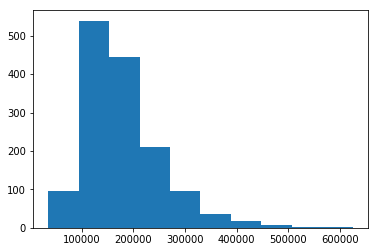

In [0]:
plt.hist(np.exp(ytr_concat))

In [0]:
pd.DataFrame(yhat).describe()

,0
count,1459.000000
mean,177991.761323
std,77467.890738
min,38064.483221
25%,126068.542473
50%,157049.925706
75%,211138.823966
max,552843.158822


(array([ 71., 482., 439., 237., 108.,  62.,  30.,  16.,   5.,   9.]),
 array([ 38064.4832208 ,  89542.35078088, 141020.21834097, 192498.08590105,
        243975.95346114, 295453.82102123, 346931.68858131, 398409.5561414 ,
        449887.42370148, 501365.29126157, 552843.15882166]),
 <a list of 10 Patch objects>)

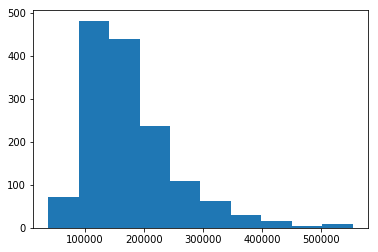

In [0]:
plt.hist(yhat)

In [0]:
yhat = pd.DataFrame(yhat)

In [0]:
yhat.to_csv(prefix+'yhat_attempt12.csv')